#Introduction

In this lab you will fit a character-level RNN that will learn to generate dinosaur species names.  This lab is (somewhat heavily) adapted from a lab in the coursera course on RNNs.

Our data set consists of the names of dinosaur species like 

We have two goals:

 * See how to set up estimation for RNNs in Keras using two different approaches:
    1. Using batches where all observed sequences are padded to the same length.  To do this, you have to add an extra symbol to the end of shorter dinosaur names so that all names have the same length and they fit neatly into an array.  This is the most straightforward way to use Keras with RNNs, but perhaps not optimal because many sequences are longer than necessary.  This can increase the potential for vanishing gradients and introduces extra computation time in forward and backward propagation.
    2. Using stochastic gradient descent with a mini-batch size of 1.  To do this you have to write a generator to create training set batches consisting of a single dinosaur name.  With this approach you don't have to do any padding, but the optimization routine will take a gradient descent update step after every single dinosaur name.  This can result in noisy updates, and slow overall convergence of the algorithm.
 * How to set up forward propagation and prediction from an RNN in numpy.  These operations are very similar, but slightly different.

Note that neither of the two easy-to-implement strategies above for fitting RNNs in Keras is really ideal.  The first isn't ideal because of the padding.  The second isn't ideal because in general we'd prefer to use mini-batch sizes greater than 1.  The only way around this is to use a custom function for optimization that aggregates gradients over multiple batches before updating.  To do this, you have to write your own optimization function rather than using one of Keras's built-in optimizers.  I think in some sense this is probably the best approach, but it's more work.  The approaches outlined above will be good enough in most cases.

## Set Runtime Type

In the Runtime menu, choose "Change runtime type" and set it to GPU if it's not set already.

## Imports

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras import utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

## Getting the data

The code below reads in the data as a list and prints out the first 30 names.

In [0]:
file_loc = utils.get_file('dino_names.txt', 'http://www.evanlray.com/data/misc/dinosaurs/dino_names.txt')

with open(file_loc) as f:
    names = f.readlines()

names = [name[:-1] for name in names]
names[0:30]

['Aachenosaurus',
 'Aardonyx',
 'Abdallahsaurus',
 'Abelisaurus',
 'Abrictosaurus',
 'Abrosaurus',
 'Abydosaurus',
 'Acanthopholis',
 'Achelousaurus',
 'Acheroraptor',
 'Achillesaurus',
 'Achillobator',
 'Acristavus',
 'Acrocanthosaurus',
 'Acrotholus',
 'Actiosaurus',
 'Adamantisaurus',
 'Adasaurus',
 'Adelolophus',
 'Adeopapposaurus',
 'Aegyptosaurus',
 'Aeolosaurus',
 'Aepisaurus',
 'Aepyornithomimus',
 'Aerosteon',
 'Aetonyx',
 'Afromimus',
 'Afrovenator',
 'Agathaumas',
 'Aggiosaurus']

## Setting Expectations

There are a few things to notice about these names:
 * They all start with a capital letter and have lower case letters after that.
 * Many of the names end with "saurus".  There are also a few other endings that show up multiple times, like "tor", "nyx", and some other consonant followed by "us".
 * They are different lengths.
 * The names alternate pretty regularly between vowels and consonants.

A successful model should capture these features of dinosaur species names, and be able to generate names with these characteristics.

## The Best Dinosaur
It's actually listed in Wikipedia.

In [16]:
print(names[714])

Kittysaurus


Here's a picture of one in the wild!

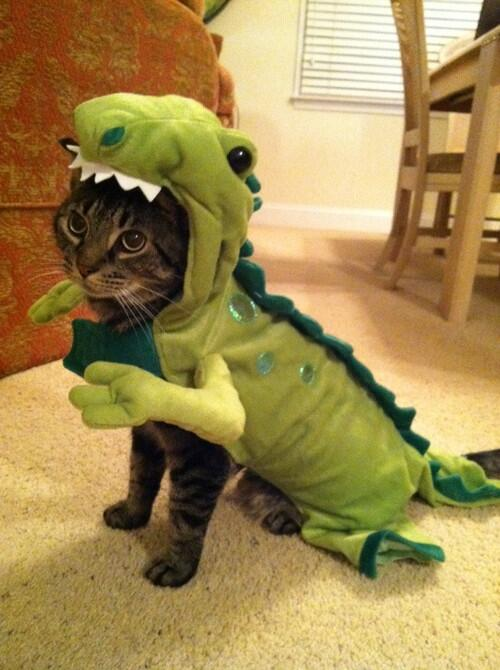

## Overall Approach

### RNN Set Up

We will use a RNN operating at the character level.  Each "time point" in a sequence corresponds to one character in the dinosaur name.  We will use the characters up to a given point in the name to predict the next character in the name.  To facilitate this, we will augment the dinosaur names with a special "start of name" tag (represented as "\<SON\>") that will be the first symbol in the name, as well as an "end of name" tag (represented as "\<EON\>") that will denote the end of each name.

For example, suppose we are looking at the name "Aardonyx".  This will be represented as "\<SON\>Aardonyx\<EON\>", and feed into our RNN as illustrated below:

![dino_rnn](http://www.evanlray.com/stat344ne_s2020/materials/20200309_RNN_lab/dino_rnn.png)

In the first estimation approach, we will pad short names with the special symbol "\<NULL\>" until reaching the length of the longest name plus 2 (since every name also has "\<SON\>" and "\<EON\>" added to it).

For example, "Aardonyx" would be represented as "\<SON\>Aardonyx\<EON\>\<NULL\>\<NULL\>\<NULL\> ... \<NULL\>", and feed into the RNN as follows:

![dino_rnn](http://www.evanlray.com/stat344ne_s2020/materials/20200309_RNN_lab/dino_rnn_nulls.png)

### Batch input sizes for Keras

Keras expects us to give it as input an array of shape (m, T, p):

 * $m$ is the number of observations
 * $T$ is the length of the sequences (must be the same for all sequences).
 * $p$ is the number of features at each time point.

### One-hot encoding

Each letter (or symbol) will be one-hot encoded to represent one of the symbols.  Our "vocabulary" will be the list of possible symbols or characters: `[\<SON\>, \<EON\>, \<NULL\>, A, B, ..., Z, a, b, ..., z]`.

We therefore have $p = 55$ features in a one-hot encoding (3 special symbols + 26 capital letters + 26 lower case letters).

A sparse encoding of "\<SON\>Aardonyx\<EON\>\<NULL\>\<NULL\>\<NULL\> ... \<NULL\>" would look like `[0, 3, 29, 46, 32, 43, 42, 53, 52, 1, 2, 2, 2, ..., 2]`

A one-hot encoding is therefore an array of shape (length of name, vocabulary size):

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & 1 & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 1 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 1 & 0 & 0 & \cdots & 0 \\
0 & 0 & 1 & 0 & 0 & \cdots & 0 \\
0 & 0 & 1 & 0 & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 1 & 0 & 0 & \cdots & 0 \\
\end{bmatrix}
$$

## Generating Names

Once we have fit the model, we can generate names one character at a time.  The key idea is that once we have generated a character for $\hat{y}^{(i)<t>}$, we use that character as the input for the next time step:

 * Initialize $a^{(i)<0>[1]} = 0$
 * Initialize $\hat{y}^{(i)<0>}$ to the \<SON\> symbol.
 * For $t = 1, \ldots, T$:
    * Set $x^{(i)\<t\>} = \hat{y}^{(i)\<t-1\>}$
    * Run one step of forward propagation to obtain $a^{(i)\<t\>[1]}$ and $a^{(i)\<t\>[2]}$
    * Generate a prediction $\hat{y}^{(i)\<t\>}$ from a $\text{Categorical}(a^{(i)\<t\>[2]})$ distribution.
    * We could break out of the loop if the \<EON\> symbol is generated.

## Utility Functions

### Functions for Encoding and Decoding Names

The functions below give functionality to perform sparse and one-hot encoding and decoding of names, optionally with padding.

You can just read through and run this code, no need to edit it.

In [17]:
max_len = np.max([len(name) for name in names])
max_len

23

What are all the characters in the data set?

In [0]:
valid_chars = ''.join(sorted({char for name in names for char in name}))

In [19]:
print(valid_chars)
print(len(valid_chars))

ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
52


In [20]:
# We will keep track of three special things:
# "Start of Name" (<SON>)
# "End of Name" (<EON>)
# "null" -- actually nothing there.  (<NULL>)
delimiters = ['<SON>', '<EON>', '<NULL>']

# dictionary to encode actual characters in dinosaur names as integers
encode_dict = {char: index+3 for index, char in enumerate(valid_chars)}

# add the special delimiters to the dictionary
for i, delim in enumerate(delimiters):
  encode_dict[delim] = i

# show the dictionary
encode_dict

{'<EON>': 1,
 '<NULL>': 2,
 '<SON>': 0,
 'A': 3,
 'B': 4,
 'C': 5,
 'D': 6,
 'E': 7,
 'F': 8,
 'G': 9,
 'H': 10,
 'I': 11,
 'J': 12,
 'K': 13,
 'L': 14,
 'M': 15,
 'N': 16,
 'O': 17,
 'P': 18,
 'Q': 19,
 'R': 20,
 'S': 21,
 'T': 22,
 'U': 23,
 'V': 24,
 'W': 25,
 'X': 26,
 'Y': 27,
 'Z': 28,
 'a': 29,
 'b': 30,
 'c': 31,
 'd': 32,
 'e': 33,
 'f': 34,
 'g': 35,
 'h': 36,
 'i': 37,
 'j': 38,
 'k': 39,
 'l': 40,
 'm': 41,
 'n': 42,
 'o': 43,
 'p': 44,
 'q': 45,
 'r': 46,
 's': 47,
 't': 48,
 'u': 49,
 'v': 50,
 'w': 51,
 'x': 52,
 'y': 53,
 'z': 54}

In [21]:
decode_dict = {ind: symbol for (symbol, ind) in encode_dict.items()}
decode_dict

{0: '<SON>',
 1: '<EON>',
 2: '<NULL>',
 3: 'A',
 4: 'B',
 5: 'C',
 6: 'D',
 7: 'E',
 8: 'F',
 9: 'G',
 10: 'H',
 11: 'I',
 12: 'J',
 13: 'K',
 14: 'L',
 15: 'M',
 16: 'N',
 17: 'O',
 18: 'P',
 19: 'Q',
 20: 'R',
 21: 'S',
 22: 'T',
 23: 'U',
 24: 'V',
 25: 'W',
 26: 'X',
 27: 'Y',
 28: 'Z',
 29: 'a',
 30: 'b',
 31: 'c',
 32: 'd',
 33: 'e',
 34: 'f',
 35: 'g',
 36: 'h',
 37: 'i',
 38: 'j',
 39: 'k',
 40: 'l',
 41: 'm',
 42: 'n',
 43: 'o',
 44: 'p',
 45: 'q',
 46: 'r',
 47: 's',
 48: 't',
 49: 'u',
 50: 'v',
 51: 'w',
 52: 'x',
 53: 'y',
 54: 'z'}

In [0]:
# adapted from https://codereview.stackexchange.com/questions/183658/replacing-letters-with-numbers-with-its-position-in-alphabet
def sparse_encode(name, pad = False):
  '''
  Get a sparse encoding of a name.

  Arguments:
   - name: string with dinosaur name
   - pad: boolean; add padding with <NULL>?
  
  Return:
   - list with integer encoding of name
  '''
  
  # get encoding of name:
  # start of name, then encoding of actual characters in name,
  # then add end of name symbol
  sparse_encoded_name = [encode_dict['<SON>']] + \
    [encode_dict[char] for char in name] + \
    [encode_dict['<EON>']]
  
  # if requested, pad with <NULL> to fill in all remaining characters
  if pad:
    sparse_encoded_name = sparse_encoded_name + \
      [encode_dict['<NULL>'] for i in range(max_len - len(name))]
  
  return(sparse_encoded_name)


def one_hot_encode_char_from_sparse(sparse_char_encoding):
  '''
  Get a one-hot encoding of a single character from its sparse encoding

  Arguments:
   - sparse_char_encoding: integer encoding of a character or symbol
  
  Returns:
   - numpy array of shape (1, 55) with one-hot encoding of character or symbol
  '''
  one_hot_encoded_char = np.zeros((len(encode_dict), 1))
  one_hot_encoded_char[sparse_char_encoding, 0] = 1.0
  
  return(one_hot_encoded_char)


def one_hot_encode(name, pad = False):
  '''
  Get a one-hot encoding of a name

  Arguments:
   - name: string with dinosaur name
   - pad: boolean; add padding with <NULL>?
  
  Return:
   - numpy array of shape (?, 55) with one-hot encoding of each character or
     symbol in name
  '''
  sparse_encoding = sparse_encode(name, pad = pad)
  one_hot_encoded_name = np.zeros((len(sparse_encoding), len(encode_dict)))
  for char_ind, sparse_char_encoding in enumerate(sparse_encoding):
    one_hot_encoded_name[char_ind, sparse_char_encoding] = 1.0

  return(one_hot_encoded_name)


def sparse_decode(sparse_encoding, keep_delimiters = False):
  '''
  Decode sparse encoding of name into string

  Arguments:
   - sparse_encoding: list of integers encoding name
   - keep_delimiters: boolean; keep a representation of delimiters in string?
  
  Return:
   - string format name
  '''
  if not keep_delimiters:
    sparse_encoding = [ind for ind in sparse_encoding if decode_dict[ind] not in delimiters]
  
  decoded = ''.join([decode_dict[ind] for ind in sparse_encoding])

  return(decoded)

def one_hot_decode(one_hot_encoding, keep_delimiters = False):
  '''
  Decode one-hot encoding of name into string

  Arguments:
   - one_hot_encoding: numpy array with one-hot encoding of name
   - keep_delimiters: boolean; keep a representation of delimiters in string?
  
  Return:
   - string format name
  '''
  sparse_encoding = np.argmax(one_hot_encoding, axis = 1)

  return(sparse_decode(sparse_encoding, keep_delimiters = keep_delimiters))


def one_hot_encode_names_with_padding(names):
  '''
  Get a one-hot encoding of all names in a list

  Arguments:
   - names: list of m strings with dinosaur names
  
  Return:
   - numpy array of shape (m, max_len + 2, 55) with one-hot encoding of each
     character or symbol in name
  '''
  one_hot_encoded_names = np.zeros((len(names), max_len + 2, len(encode_dict)))
  for i, name in enumerate(names):
    one_hot_encoded_names[i, ...] = one_hot_encode(name, pad = True)
  
  return(one_hot_encoded_names)

In [23]:
print(names[1])

# sparse encoding without padding
print(sparse_encode(names[1], pad = False))

Aardonyx
[0, 3, 29, 46, 32, 43, 42, 53, 52, 1]
(10, 55)


In [24]:
# sparse encoding with padding
print(sparse_encode(names[1], pad = True))

[0, 3, 29, 46, 32, 43, 42, 53, 52, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [25]:
# one-hot encode without padding.
# first dimension of shape is 10 since the representation is
# <SON> + 8 characters in the name + <EON>
# second dimension of shape is 55 since there are 55 possible characters/symbols
print(one_hot_encode(names[1], pad = False).shape)

(10, 55)


In [27]:
# one-hot encode with padding.
# first dimension of shape is 25 since the representation is
# <SON> + 8 characters in the name + <EON> + <NULL>'s padded to total length of 25
# second dimension of shape is 55 since there are 55 possible characters/symbols
print(one_hot_encode(names[1], pad = True).shape)

(25, 55)


In [30]:
# one-hot encode all names
# first dimension of shape is the number of names (m)
# second dimension is 25 since all names are padded
# third dimension is 55 since there are 55 possible characters/symbols
one_hot_encoded_names = one_hot_encode_names_with_padding(names)
print(one_hot_encoded_names.shape)

(1535, 25, 55)


### Functions for Simulating Names

#### 1. Fill in the missing code for the forward propagation step and simulation below.

In [0]:
def rnn_forward_prop_one_step(x_t, a1_tm1, parameters):
    '''
    Do forward propagation for one time step of a RNN

    Arguments:
     - x_t: input data at time step t.  numpy array of shape (p, 1).
     - a1_tm1: activation for layer 1 at time step t-1 ("t minus 1").
       numpy array of shape (n_1, 1)
     - parameters: python dictionary containing:
         b1: numpy array of shape (n_1, 1)
         Wx1: numpy array of shape (p, n_1)
         Wa1: numpy array of shape (n_1, n_1)
         b2: numpy array of shape (n_2, 1)
         W2: numpy array of shape (n_1, n_2)
    
    Returns:
     - tuple containing activation outputs for layers 1 and 2 at time t
    '''
    
    # Retrieve parameters from "parameters"
    b1 = parameters["b1"]
    Wx1 = parameters["Wx1"]
    Wa1 = parameters["Wa1"]
    b2 = parameters["b2"]
    W2 = parameters["W2"]
    
    # compute next RNN layer activation
    # Replace None in the line below with a calculation of z for the RNN layer
    z1_t = np.dot(Wa1.T, a1_tm1) + np.dot(Wx1.T, x_t) + b1
    # Replace None in theline below with calculation of a for the RNN layer
    # using a tanh activation function (np.tanh)
    a1_t = np.tanh(z1_t)

    # compute output layer activation
    # Replace None in the line below with a calculation of z for the output layer
    z2_t = np.dot(W2.T, a1_t) + b2
    # Replace None in the line below with a calculation of a for the output layer
    # use the softmax function
    a2_t = softmax(z2_t, axis = 0)
    
    return a1_t, a2_t

#### 2. Fill in the missing code to simulate names below:

 * Initialize $a^{(i)<0>[1]} = 0$
 * Initialize $\hat{y}^{(i)<0>}$ to the \<SON\> symbol.
 * For $t = 1, \ldots, T$:
    * Set $x^{(i)<t>} = \hat{y}^{(i)<t-1>}$
    * Run one step of forward propagation to obtain $a^{(i)<t>[1]}$ and $a^{(i)<t>[2]}$
    * Generate a prediction $\hat{y}^{(i)<t>}$ from a $\text{Categorical}(a^{(i)<t>[2]})$ distribution.

In [0]:
def simulate_name_sparse_encoding(parameters, max_len, eon_break = False):
  '''
  Simulate a dinosaur name using a sparse encoding

  Arguments:
   - parameters: python dictionary containing:
         b1: numpy array of shape (n_1, 1)
         Wx1: numpy array of shape (p, n_1)
         Wa1: numpy array of shape (n_1, n_1)
         b2: numpy array of shape (n_2, 1)
         W2: numpy array of shape (n_1, n_2)
   - max_len: int, maximum length of name to generate
   - eon_break: boolean; stop generating characters if <EON> is generated?
  '''

  # Initialize a1_t to be a numpy array of zeros
  # Use the np.zeros function with appropriate shape
  # We will have 64 units in our RNN layer
  a1_t = np.zeros((64, 1))
  
  # Initialize at '<SON>'
  y_t = encode_dict['<SON>']
  y = [y_t]

  for i in range(max_len):
    # Update a1_tm1 ("t minus 1") to be the activation output from
    # the last time step, which is currently stored in a1_t
    a1_tm1 = a1_t

    # get a one-hot encoding of the y from the previous time step,
    # which is currrently stored stored in y_t
    x_t = one_hot_encode_char_from_sparse(y_t)

    # run forward propagation
    a1_t, a2_t = rnn_forward_prop_one_step(x_t, a1_tm1, parameters)

    # randomly choose the next output based on the probabilities stored in a2_t
    y_t = np.random.choice(len(encode_dict), size = 1, p = a2_t[:,0])
    
    # convert y_t to a python list (instead of numpy array) and append to y
    y_t = y_t.tolist()
    y = y + y_t

    # break if requested and <EON> was generated
    if eon_break and y_t[0] == encode_dict['<EON>']:
      break

  return(y)

### Train/Test Split
We'll use the following train/test split across all estimation approaches.

In [0]:
train_names, val_names = train_test_split(names, test_size = 0.2)

## Estimation Approach 1: Padding Names to the Same Length

The code below gets the one-hot encoding of the names.

In [37]:
train_names_one_hot = one_hot_encode_names_with_padding(train_names)
print("train names shape = " + str(train_names_one_hot.shape))
val_names_one_hot = one_hot_encode_names_with_padding(val_names)
print("val names shape = " + str(val_names_one_hot.shape))

train names shape = (1228, 25, 55)
val names shape = (307, 25, 55)


This is what it looks like when we "decode" them back to strings:

In [40]:
one_hot_decode(train_names_one_hot[0])

'Arizonasaurus'

In [41]:
one_hot_decode(train_names_one_hot[0], keep_delimiters=True)

'<SON>Arizonasaurus<EON><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL>'

#### 3. Slice the names to get training and validation set X and y
Specify the slice indices below.  The inputs X should be the characters up to but not including the last character.  The output y should be the characters starting from the second and going to the end of the sequence.

In [0]:
train_names_X = train_names_one_hot[:, :-1, :]
train_names_y = train_names_one_hot[:, 1:, :]

val_names_X = val_names_one_hot[:, :-1, :]
val_names_y = val_names_one_hot[:, 1:, :]

## RNN Model
Let's build a first RNN.

#### 4. Define and compile a Sequential model using the following architecture:

 * First layer is a `SimpleRNN` with:
    * 64 units
    * `return_sequences = True`
    * `input_shape = (___, ___)`.  Fill in the blanks with the correct shape.
 * Second layer is an appropriately defined Dense layer for predicting characters.

Compile the model using `'adam'` or `'rmsprop'` as the optimizer and the appropriate loss.

In [0]:
rnn_model = models.Sequential()
rnn_model.add(layers.SimpleRNN(64, return_sequences=True, input_shape=train_names_X.shape[1:3]))
rnn_model.add(layers.Dense(len(encode_dict), activation='softmax'))

rnn_model.compile(optimizer='adam', loss = 'categorical_crossentropy')

#### 5. Run estimation for 5 epochs with a batch size of 128
This is not long enough to really fit the model.  This way you'll get to see what kinds of names the model generates early in training.

In [84]:
rnn_model.fit(
    train_names_X, train_names_y, batch_size = 128, epochs = 5, validation_data = (val_names_X, val_names_y)
)

Train on 1228 samples, validate on 307 samples
Epoch 1/5
1228/1228 [==============================] - 1s 540us/step - loss: 3.7311 - val_loss: 3.2355
Epoch 2/5
1228/1228 [==============================] - 0s 178us/step - loss: 2.8577 - val_loss: 2.4837
Epoch 3/5
1228/1228 [==============================] - 0s 158us/step - loss: 2.3427 - val_loss: 2.2176
Epoch 4/5
1228/1228 [==============================] - 0s 177us/step - loss: 2.1164 - val_loss: 2.0345
Epoch 5/5
1228/1228 [==============================] - 0s 178us/step - loss: 1.9501 - val_loss: 1.8711


Run the code below a few times to generate some names from your model fit.  They probably won't be too impressive.

In [91]:
# extract parameter estimates
layer_1_params = rnn_model.layers[0].get_weights()
layer_2_params = rnn_model.layers[1].get_weights()
param_estimates = {
    'b1': layer_1_params[2].reshape((len(layer_1_params[2]), 1)),
    'Wx1': layer_1_params[0],
    'Wa1': layer_1_params[1],
    'b2': layer_2_params[1].reshape((len(layer_2_params[1]), 1)),
    'W2': layer_2_params[0]
}

# generate a random name from the model
name_sparse_encoding = simulate_name_sparse_encoding(parameters = param_estimates, max_len = 50)

# decode and print the generated name
print("generated name with delimiters: ")
print(sparse_decode(name_sparse_encoding, keep_delimiters=True))

print("\ngenerated name without delimiters: ")
print(sparse_decode(name_sparse_encoding, keep_delimiters=False))

generated name with delimiters: 
<SON>StN<EON>a<NULL>sqA<NULL>ol<NULL><NULL><NULL>s<NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><EON><NULL><NULL>oi<NULL><NULL><NULL>r<NULL><NULL><NULL>rn<NULL><NULL><NULL><NULL>r<NULL><NULL><NULL><NULL><NULL><NULL><NULL>

generated name without delimiters: 
StNasqAolsoirrnr


#### 6. Continue training for another 50 epochs

In [92]:
rnn_model.fit(
    train_names_X, train_names_y, batch_size = 128, epochs = 50, validation_data = (val_names_X, val_names_y)
)

Train on 1228 samples, validate on 307 samples
Epoch 1/50
1228/1228 [==============================] - 0s 197us/step - loss: 1.8101 - val_loss: 1.7600
Epoch 2/50
1228/1228 [==============================] - 0s 163us/step - loss: 1.7165 - val_loss: 1.6870
Epoch 3/50
1228/1228 [==============================] - 0s 171us/step - loss: 1.6549 - val_loss: 1.6372
Epoch 4/50
1228/1228 [==============================] - 0s 173us/step - loss: 1.6110 - val_loss: 1.6024
Epoch 5/50
1228/1228 [==============================] - 0s 191us/step - loss: 1.5776 - val_loss: 1.5686
Epoch 6/50
1228/1228 [==============================] - 0s 179us/step - loss: 1.5455 - val_loss: 1.5409
Epoch 7/50
1228/1228 [==============================] - 0s 180us/step - loss: 1.5175 - val_loss: 1.5125
Epoch 8/50
1228/1228 [==============================] - 0s 175us/step - loss: 1.4891 - val_loss: 1.4875
Epoch 9/50
1228/1228 [==============================] - 0s 161us/step - loss: 1.4607 - val_loss: 1.4560
Epoch 10/50
1228/

Run the code below a few times to generate some names from your updated model fit.  You should see that the model is doing better.  Probably the names mostly start with a capital letter, mostly have lower case letters after that, and mostly end with an \<EON\> tag followed by \<NULL\> tags.

In [105]:
# extract parameter estimates
layer_1_params = rnn_model.layers[0].get_weights()
layer_2_params = rnn_model.layers[1].get_weights()
param_estimates = {
    'b1': layer_1_params[2].reshape((len(layer_1_params[2]), 1)),
    'Wx1': layer_1_params[0],
    'Wa1': layer_1_params[1],
    'b2': layer_2_params[1].reshape((len(layer_2_params[1]), 1)),
    'W2': layer_2_params[0]
}

# generate a random name from the model
name_sparse_encoding = simulate_name_sparse_encoding(parameters = param_estimates, max_len = 50)

# decode and print the generated name
print("generated name with delimiters: ")
print(sparse_decode(name_sparse_encoding, keep_delimiters=True))

print("\ngenerated name without delimiters: ")
print(sparse_decode(name_sparse_encoding, keep_delimiters=False))

generated name with delimiters: 
<SON>Datosaurus<EON><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL>

generated name without delimiters: 
Datosaurus


#### 7. Continue training for another 100 epochs.

In [104]:
rnn_model.fit(
    train_names_X, train_names_y, batch_size = 128, epochs = 100, validation_data = (val_names_X, val_names_y)
)

Train on 1228 samples, validate on 307 samples
Epoch 1/100
1228/1228 [==============================] - 0s 188us/step - loss: 0.9967 - val_loss: 1.0235
Epoch 2/100
1228/1228 [==============================] - 0s 180us/step - loss: 0.9934 - val_loss: 1.0204
Epoch 3/100
1228/1228 [==============================] - 0s 172us/step - loss: 0.9903 - val_loss: 1.0174
Epoch 4/100
1228/1228 [==============================] - 0s 170us/step - loss: 0.9872 - val_loss: 1.0142
Epoch 5/100
1228/1228 [==============================] - 0s 168us/step - loss: 0.9833 - val_loss: 1.0113
Epoch 6/100
1228/1228 [==============================] - 0s 170us/step - loss: 0.9795 - val_loss: 1.0092
Epoch 7/100
1228/1228 [==============================] - 0s 177us/step - loss: 0.9763 - val_loss: 1.0070
Epoch 8/100
1228/1228 [==============================] - 0s 163us/step - loss: 0.9734 - val_loss: 1.0054
Epoch 9/100
1228/1228 [==============================] - 0s 165us/step - loss: 0.9707 - val_loss: 1.0026
Epoch 10

Run the code below a few times to generate some names from your updated model fit.  You should see that the model is doing even better.  The names should mostly start with a capital letter and have all lower case letters after that.  They will often end with common dinosaur name endings like "saurus" and "tops".

In [117]:
# extract parameter estimates
layer_1_params = rnn_model.layers[0].get_weights()
layer_2_params = rnn_model.layers[1].get_weights()
param_estimates = {
    'b1': layer_1_params[2].reshape((len(layer_1_params[2]), 1)),
    'Wx1': layer_1_params[0],
    'Wa1': layer_1_params[1],
    'b2': layer_2_params[1].reshape((len(layer_2_params[1]), 1)),
    'W2': layer_2_params[0]
}

# generate a random name from the model
name_sparse_encoding = simulate_name_sparse_encoding(parameters = param_estimates, max_len = 50)

# decode and print the generated name
print("generated name with delimiters: ")
print(sparse_decode(name_sparse_encoding, keep_delimiters=True))

print("\ngenerated name without delimiters: ")
print(sparse_decode(name_sparse_encoding, keep_delimiters=False))

generated name with delimiters: 
<SON>Suagosaurus<EON><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL><NULL>

generated name without delimiters: 
Suagosaurus


## Estimation Approach 2: Generating Batches of Size 1

Having to deal with all of those extra \<NULL\>s was kindof annoying, but necessary to be able to give batches of more than one observation at a time to Keras.

Here we take a different approach, generating batches of just one observation at a time.  Keras allows different batches to have different numbers of time points, so we don't need to do the padding.

To do this, we have to define a generator.  Recall that this works in three stages:

1. Write a generator function.  The way I think about it, the code in this generator function looks like the code the actual generator object will run when next is called on it.
2. Call the generator function to create a generator object.
3. Now when you call `next` on the generator object, it will create and yield (basically the same as return) the next thing that it generates.  In our case, this means it will yield the next batch.  Conceptually, a batch is a tuple `(X, y)` to be used for one gradient descent step.

I've done this for you because I couldn't figure out a good way to make you do part of it.  But some day I will make you write one of these.

In [0]:
def make_generator(names_list):
  '''
  Generator function; creates a generator object that yields batches of data
  created from one-hot encoding one name selected from names_list

  Arguments:
   - names_list: a list of names from which to create batches
  
  Yields:
   - A tuple (X, y) with RNN inputs and outputs for a single randomly selected name
  '''
  # name_indices is currently the integers from 0 to len(names_list)-1
  # these are the indices of names to draw from
  name_indices = np.arange(len(names_list))

  # i is which name index we want to yield
  i = 0

  # while True means "never stop yielding more batches"
  while True:
    # if we reached the end of the names list, shuffle them up and start over
    if i % len(names_list) == 0:
      i = 0
      np.random.shuffle(name_indices)
    
    # extract the name we want for this batch
    name = names_list[name_indices[i]]

    # one hot encode the name.  After this line, shape is (1, ?, 55)
    # where ? varies from batch to batch based on the length of the sampled name
    one_hot_encoded_name = one_hot_encode(name, pad = False)[np.newaxis, ...]

    # extract X and y from the one hot encoding
    X = one_hot_encoded_name[:, :-1, :]
    y = one_hot_encoded_name[:, 1:, :]

    # increment i
    i += 1

    # yield the result
    yield X, y

# create a generator for the training set and validation set
train_gen = make_generator(train_names)
val_gen = make_generator(val_names)

Here's what happens if we call next

In [211]:
one_hot_name_X, one_hot_name_y = next(train_gen)

print("X shape = " + str(one_hot_name_X.shape))

print("decoded X = " + one_hot_decode(one_hot_name_X[0, ...], keep_delimiters=True))

print("decoded y = " + one_hot_decode(one_hot_name_y[0, ...], keep_delimiters=True))

X shape = (1, 16, 55)
decoded X = <SON>Zhongyuansaurus
decoded y = Zhongyuansaurus<EON>


#### 8. Define a sequential model with the same structure as before.

The only difference is that you should specify `input_shape = (None, 55)`.  This says to Keras, "I'm not telling you how many time points are in my sequences right now."  We need to do this since different batches will have different numbers of time points.

In [0]:
rnn_model_batch1 = models.Sequential()
rnn_model_batch1.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(None, 55)))
rnn_model_batch1.add(layers.Dense(len(encode_dict), activation='softmax'))

rnn_model_batch1.compile(optimizer='adam', loss = 'categorical_crossentropy')

#### 9. Fit the model using the `fit_generator` function using 10 epochs.

You'll need to provide:

 * `train_gen`
 * `steps_per_epoch` = the number of names in the training set
 * `epochs = 10`
 * `validation_data = val_gen`
 * `validation_steps` = the number of names in the validation set

In [194]:
rnn_model_batch1.fit_generator(
  train_gen,
  steps_per_epoch=len(train_names),
  epochs=10,
  validation_data=val_gen,
  validation_steps=len(val_names))

Epoch 1/10
1228/1228 [==============================] - 10s 8ms/step - loss: 2.3270 - val_loss: 2.0256
Epoch 2/10
1228/1228 [==============================] - 9s 7ms/step - loss: 1.9558 - val_loss: 1.9502
Epoch 3/10
1228/1228 [==============================] - 9s 7ms/step - loss: 1.8554 - val_loss: 1.8397
Epoch 4/10
1228/1228 [==============================] - 9s 7ms/step - loss: 1.8015 - val_loss: 1.8116
Epoch 5/10
1228/1228 [==============================] - 9s 7ms/step - loss: 1.7601 - val_loss: 1.7991
Epoch 6/10
1228/1228 [==============================] - 9s 7ms/step - loss: 1.7292 - val_loss: 1.7728
Epoch 7/10
1228/1228 [==============================] - 9s 7ms/step - loss: 1.7029 - val_loss: 1.7705
Epoch 8/10
1228/1228 [==============================] - 9s 7ms/step - loss: 1.6808 - val_loss: 1.7642
Epoch 9/10
1228/1228 [==============================] - 9s 7ms/step - loss: 1.6531 - val_loss: 1.7822
Epoch 10/10
1228/1228 [==============================] - 9s 7ms/step - loss: 1.64

Run the code below a few times to generate some names from your model fit.  You should see that the model is doing pretty well after only 10 epochs.  The names should mostly start with a capital letter and have all lower case letters after that.  They will often end with common dinosaur name endings like "saurus" and "tops".

Relative to the first model each epoch took longer (because we were working with batch sizes of 1, we did not really make use of vectorization and our fancy GPU hardware).

However, this model is roughly as good after training for 10 epochs as the first model was after training for 150 epochs.  I think this is mainly because we used mini-batch gradient descent with batch size of 1, so there were over 1000 gradient descent steps taken per epoch.  However, it may also help that our problem is now a little simpler (no NULL tags to learn about) and the names were generally shorter without padding (so vanishing gradients may be slightly less of an issue).

In [212]:
# extract parameter estimates
layer_1_params = rnn_model_batch1.layers[0].get_weights()
layer_2_params = rnn_model_batch1.layers[1].get_weights()
param_estimates = {
    'b1': layer_1_params[2].reshape((len(layer_1_params[2]), 1)),
    'Wx1': layer_1_params[0],
    'Wa1': layer_1_params[1],
    'b2': layer_2_params[1].reshape((len(layer_2_params[1]), 1)),
    'W2': layer_2_params[0]
}

# generate a random name from the model
name_sparse_encoding = simulate_name_sparse_encoding(parameters = param_estimates, max_len = 50, eon_break = True)

# decode and print the generated name
print("generated name with delimiters: ")
print(sparse_decode(name_sparse_encoding, keep_delimiters=True))

print("\ngenerated name without delimiters: ")
print(sparse_decode(name_sparse_encoding, keep_delimiters=False))

generated name with delimiters: 
<SON>Thukiguchiau<EON>

generated name without delimiters: 
Thukiguchiau
